#Introduction

Having a precise hourly forecast of transmitted energy in District Heating Systems (DHS) allows operators to micro-manage the systems more effectively, reduce operational costs, minimize environmental impacts, and improve service reliability and customer satisfaction.

In this paper, we show that modern Deep Learning (DL) methods can be used for sufficiently accurate sequence forecasting, enabling the insight into precise breakdown of heat demand over the next 24 hours. Such insight facilitates fine-tuned decision making in the daily operation of DHS. The fine tuning could be related to adjusting production levels due to forecasted lower or higher demand, secondary flow (at the substation level) management in response to forecasted varying demand across DHS districts, scheduling maintenance and repairs at low demand (for example, overnight), etc.

Our hypothesis is that the use of modern DL sequence forecasting models, combined with the custom feature engineering approach that considers also weather forecast data, can result with the accuracy which: a) is comparable with single-step forecasting accuracy, b) has stable distribution across the whole forecasted sequences.

The method we use involves custom feature engineering practices and state-of-the-art Transformer algorithm for training the model, adapted for time series forecasting problems. To prove the hypothesis, we work with the selected local DHS substation data, namely transmitted energy time series with 38710 time points, covering 5 heating seasons in period 2019-2024.

Our model trained without weather forecast data exhibits the Mean Absolute Error (MAE) of 28.15 KWh, which is actually an improvement over the benchmark single-step model, trained by using stacked Long-Short Term Memory (LSTM) network (MAE=28.73 KWh). When weather forecast features are added, the model shows significant improvement (MAE=21.09 KWh). Finally, the model exhibits almost even distribution across hours in the forecasting horizon (sequence), with standard deviation of MAE of 0.23 KWh. Vanilla Transformer model adapted for time series problems was used, trained in 5 epochs.


## What is District Heating System and how it works?

A District Heating System is a centralized method of providing heat to multiple buildings through a network of insulated pipes that deliver hot water or steam from a central source. This system is used to efficiently heat residential, commercial, and industrial buildings within a specific district or area.

The components of the DHS are DHS plant or central heat source, the distribution network with insulated pipes transporting the hot water or steam from the central source to the buildings. These pipes form two closed loops, namely primary flow (heating fluid supply and return from central plant to substations) and secondary flow (heating fluid supply and return from substations to consumers). Heat is transferred from primary to secondary flow by heat exchangers, located at substations.

Find below illustration of small DHS we are working with, including 5 substations (L4, L8, L12, L17 and L22). Figure also shows location of measurement of the most important data in our datasets.

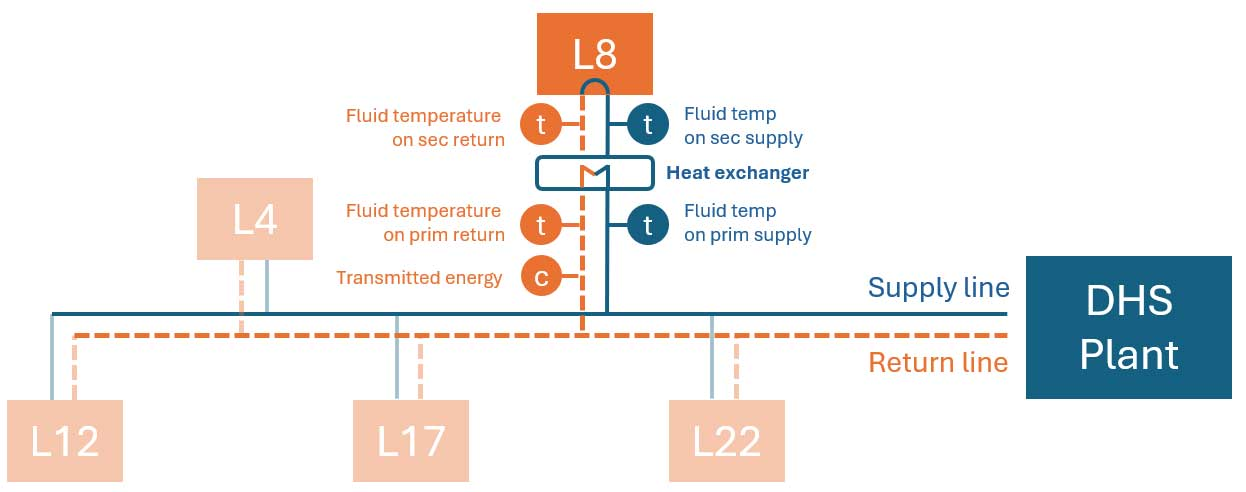

Let's start with importing the neccessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

from tqdm import tqdm

# Data processing and feature engineering

All data from 5 substations of the local DHS and meteorological data is stored in GitHub folder.

In [ ]:
github_folder = 'https://github.com/xai4heat/xai4heat/raw/main/datasets/'
files = ['xai4heat_scada_L4.csv',
         'xai4heat_scada_L8.csv',
         'xai4heat_scada_L12.csv',
         'xai4heat_scada_L17.csv',
         'xai4heat_scada_L22.csv']

weather_file='weather/ni_20_rs.csv'

Weather dataset is open and some obviously irrelevant data is removed.

In [ ]:
dfw = pd.read_csv(github_folder+weather_file)

dfw['datetime'] = pd.to_datetime(dfw['datetime'])
dfw.set_index('datetime',inplace=True)

# Removing irrelevant data
dfw=dfw.drop(['name',
              'precipprob',
              'preciptype',
              'icon',
              'stations'], axis=1)

All substations data is open, some initial pre-processing is done, data is merged with weather data and resulting datasets are stored in a list for later use. Initial pre-processing includes stripping data out of hourly time series and off-season data. November 1st and April 1st are adopted as dates for a heating season start and end - normally season starts earlier and ends later, but those periods are characterized by irregularities, such as testing the system, very unbalanced consumption etc., hence they are discarded.

Also, the numbers of time points with zero transmitted energy are displayed below. Such situation correspond to data transmission failures and it needs appropriate treatment.

In [ ]:
def strip_out_season_data(df):
  date_range_season1 = (df.index >= pd.to_datetime('2018-11-01 06:00:00')) & (df.index < pd.to_datetime('2019-04-01 23:00:00'))
  date_range_season2 = (df.index >= pd.to_datetime('2019-11-01 06:00:00')) & (df.index < pd.to_datetime('2020-04-01 23:00:00'))
  date_range_season3 = (df.index >= pd.to_datetime('2020-11-01 06:00:00')) & (df.index < pd.to_datetime('2021-04-01 23:00:00'))
  date_range_season4 = (df.index >= pd.to_datetime('2021-11-01 06:00:00')) & (df.index < pd.to_datetime('2022-04-01 23:00:00'))
  date_range_season5 = (df.index >= pd.to_datetime('2022-11-01 06:00:00')) & (df.index < pd.to_datetime('2023-04-01 23:00:00'))
  date_range_season6 = (df.index >= pd.to_datetime('2023-11-01 06:00:00')) & (df.index < pd.to_datetime('2024-04-01 23:00:00'))
  df = df[date_range_season1 | date_range_season2 | date_range_season3 | date_range_season4 | date_range_season5 | date_range_season6]
  return df


all_data=[]
for i in files:
  df = pd.read_csv(github_folder+i)
  df['datetime'] = pd.to_datetime(df['datetime'])
  df.set_index('datetime',inplace=True)

  # For each sub, show data acquisition periods
  print(i)
  print('Timeline (from/to): ', df.index.min(), df.index.max())

  # Remove data outside of the heating season
  df=strip_out_season_data(df)

  # Strip all data except data acquired at full hour
  df = df[df.index.minute == 0]

  #Insert missing timepoints, populate with NaNs
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
  df = df.reindex(complete_time_index)

  #Show number of enery zero data - inaccurate readings at calorimeter
  zero_count = (df['e'] == 0).sum()
  print('Data transmission failures: ', str(zero_count)+'/'+str(len(df)))

  #Merging with weather data
  df = pd.merge(df, dfw, left_index=True, right_index=True, how='inner')

  all_data.append(df)

xai4heat_scada_L4.csv
Timeline (from/to):  2019-08-05 13:00:00 2024-04-04 11:52:00
Data transmission failures:  2200/38712
xai4heat_scada_L8.csv
Timeline (from/to):  2021-05-25 13:00:00 2024-04-04 11:52:00
Data transmission failures:  13/21168
xai4heat_scada_L12.csv
Timeline (from/to):  2021-05-25 13:00:00 2024-04-04 11:52:00
Data transmission failures:  16/21168
xai4heat_scada_L17.csv
Timeline (from/to):  2019-08-05 13:00:00 2024-04-04 11:52:00
Data transmission failures:  89/38712
xai4heat_scada_L22.csv
Timeline (from/to):  2021-05-25 13:00:00 2024-04-04 11:52:00
Data transmission failures:  64/21168


Let's address missing transmitted energy data. First, zero data in e column is replaced with NaNs, as calorimeter reading cannot be zero. Then, for all other columns, only data corresponding to the location of zero data in e column is replaced with NaNs. Finally, all NaNs are imputed by using simple linear interpolation which is considered a sufficiently good approximation for the hourly time series data.

This approach follows the assumption that zero data in calorimeter reading corresponds to the issue in transmission, affecting also readings of the fluid and ambient temperature sensors. Zero data by the temperature sensors is not strong indication of a transmission failure, especially when considering the ambient temperature sensor which obviously may read a zero temperature.

In [ ]:
columns_to_update = ['t_amb', 't_ref', 't_sup_prim', 't_ret_prim', 't_sup_sec', 't_ret_sec']

for i, dfa in enumerate(all_data):
  dfa['e'] = dfa['e'].replace(0, np.nan)
  for column in columns_to_update:
    dfa.loc[dfa['e'].isna(), column] = np.nan
  dfa.interpolate(method='linear', inplace=True)
  all_data[i]=dfa

For visual inspection, signals corresponding to transmitted energy and temperatures of supply and return flow fluids in secondary line are plotted. Also, simple z-score method is used to identify the outliers in fluid temperatures in a secondary flow. All data with z_score > 5 is considered an outlier and irregular data, to be treated appropriately.

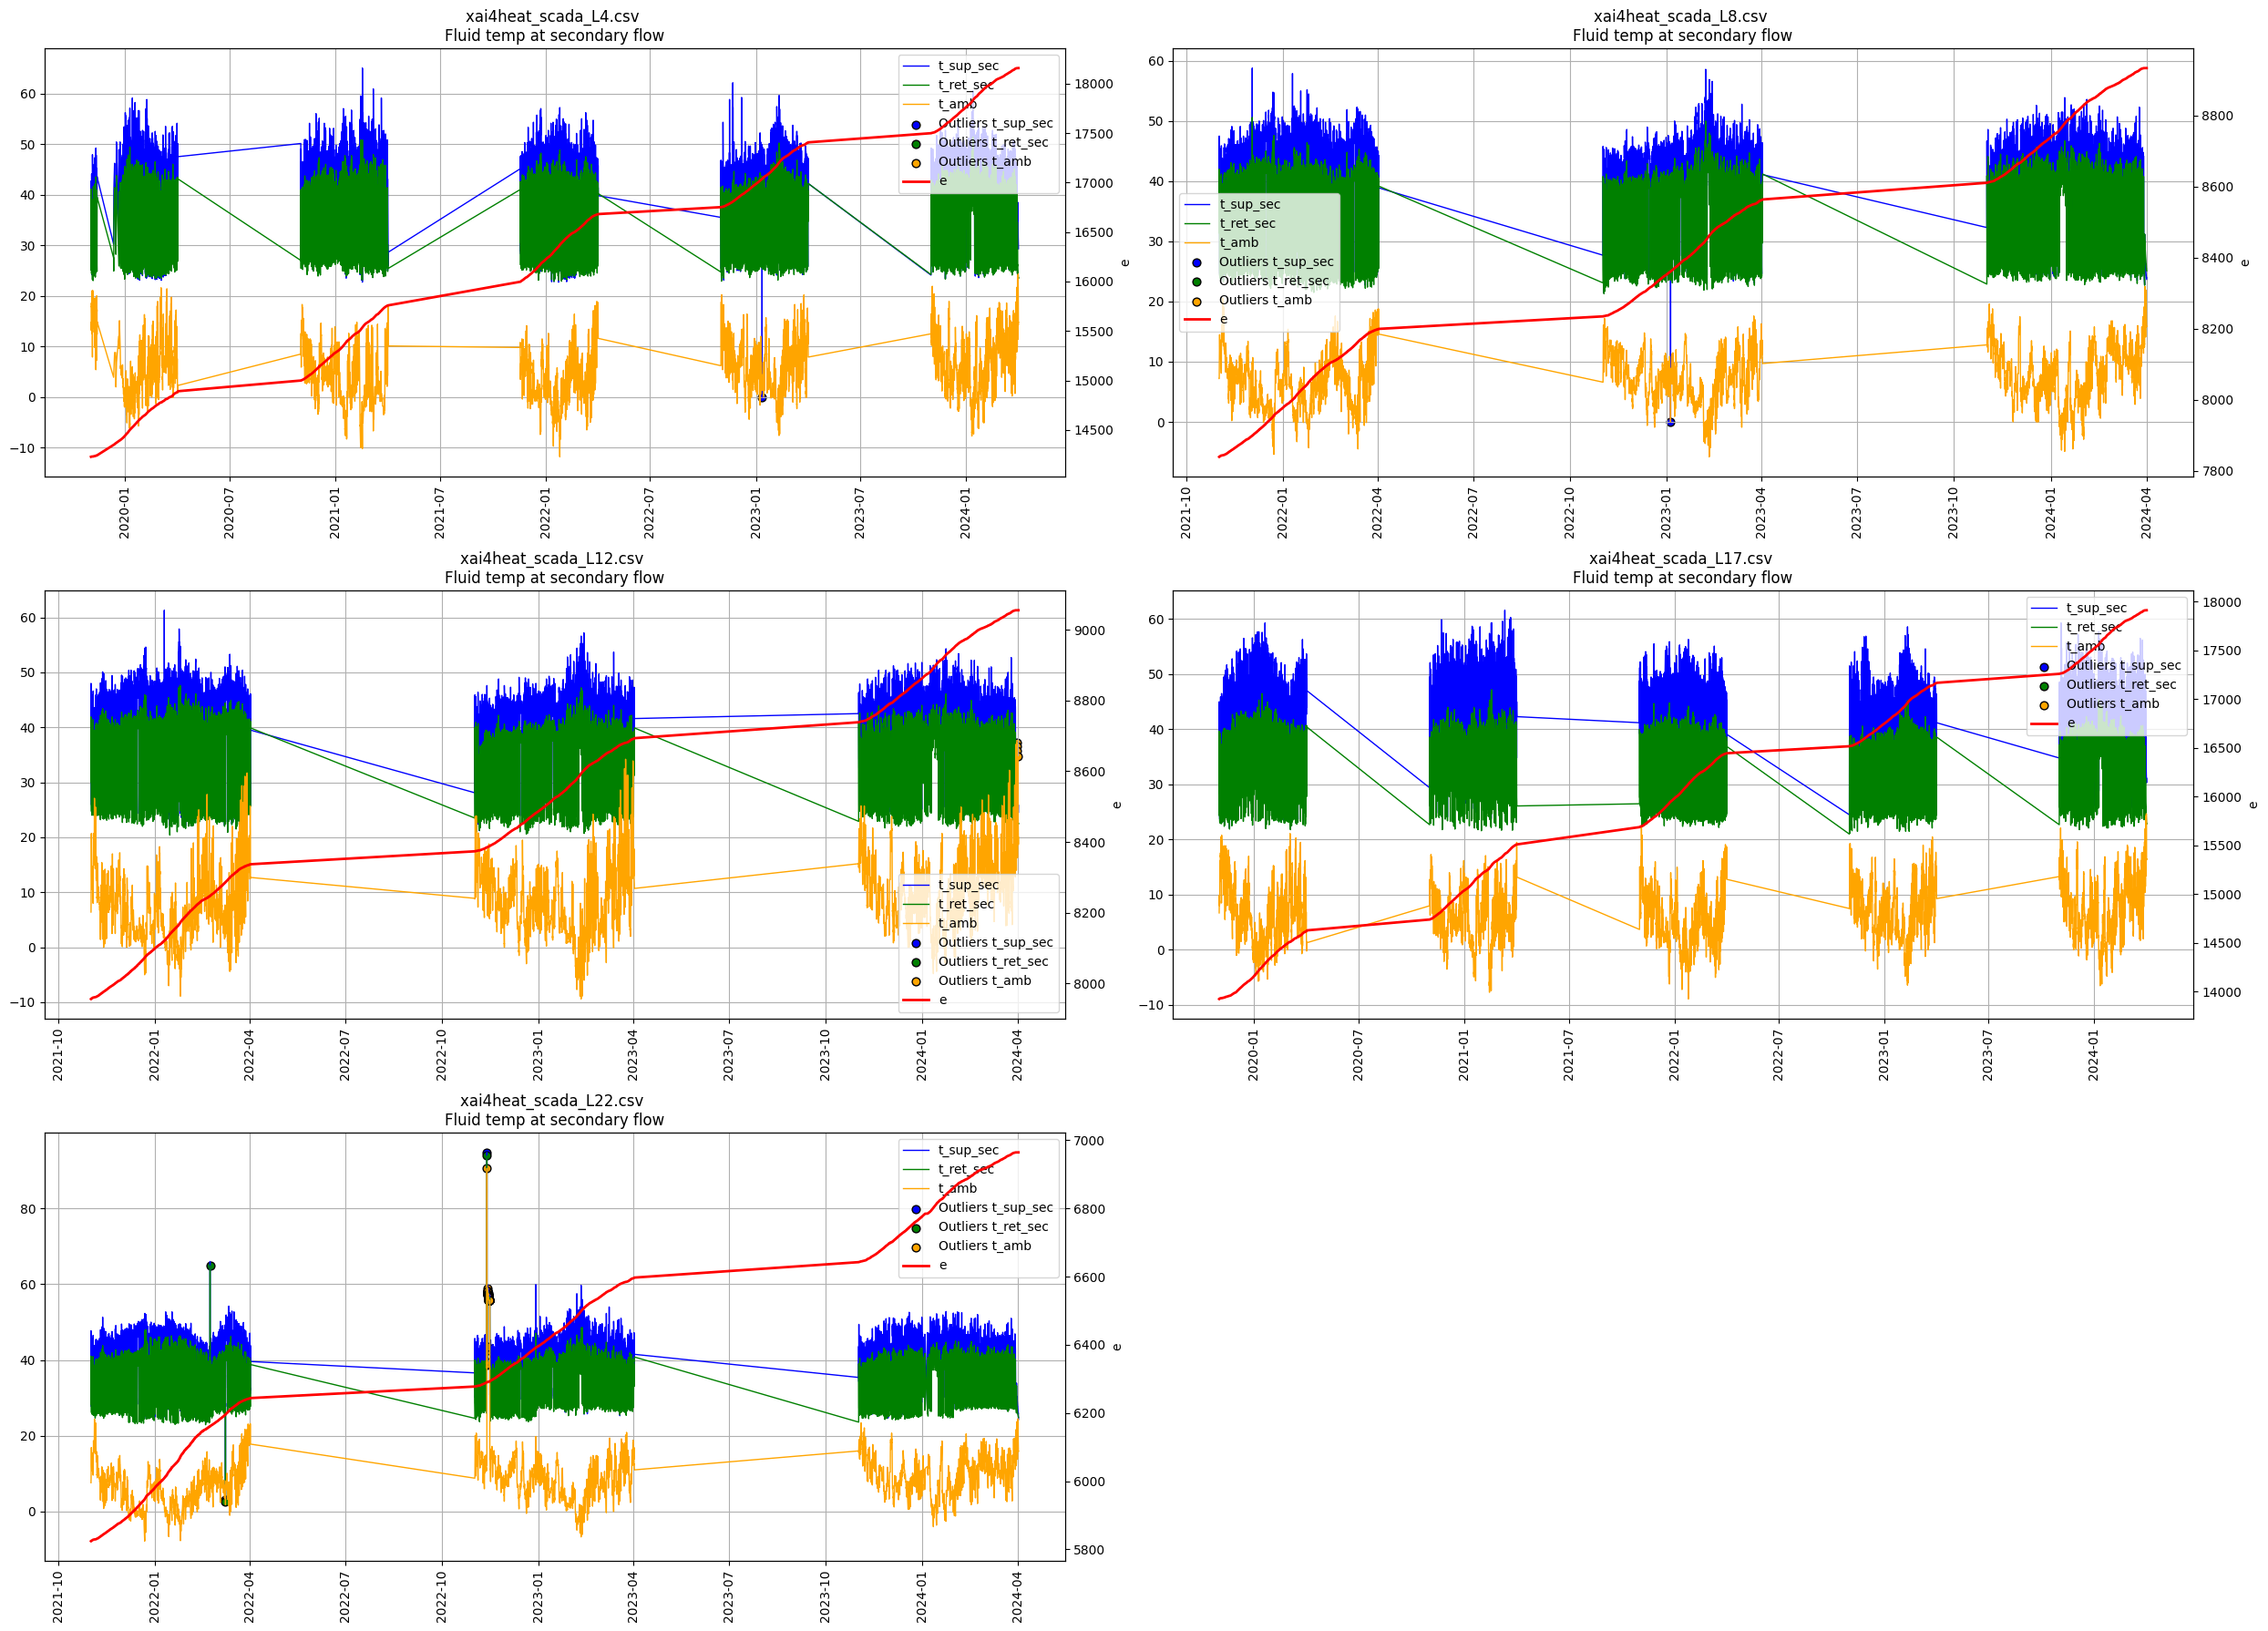

In [ ]:
num_plots = len(all_data)
num_rows = math.ceil(num_plots / 2)


def find_outliers(series):
    """Calculate z-scores and identify outliers in a series."""
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    return series[np.abs(z_scores) > 5]


# Create subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(25, 6*num_rows))

axs = axs.flatten()

# Loop through each DataFrame in the list
for i, df in enumerate(all_data):
    axs[i].plot(df['t_sup_sec'], label='t_sup_sec', linewidth=1, color='blue')
    axs[i].plot(df['t_ret_sec'], label='t_ret_sec', linewidth=1, color='green')
    axs[i].plot(df['t_amb'], label='t_amb', linewidth=1, color='orange')

    # Calculate and plot outliers for t_sup_sec
    outliers_sup = find_outliers(df['t_sup_sec'])
    axs[i].scatter(outliers_sup.index, outliers_sup, color='blue', s=40, label='Outliers t_sup_sec', edgecolors='k')

    # Calculate and plot outliers for t_ret_sec
    outliers_ret = find_outliers(df['t_ret_sec'])
    axs[i].scatter(outliers_ret.index, outliers_ret, color='green', s=40, label='Outliers t_ret_sec', edgecolors='k')

    # Calculate and plot outliers for t_amb
    outliers_amb = find_outliers(df['t_amb'])
    axs[i].scatter(outliers_amb.index, outliers_amb, color='orange', s=40, label='Outliers t_amb', edgecolors='k')


    axs_e = axs[i].twinx()
    axs_e.plot(df.index, df['e'], color='red', label='e', linewidth=2)
    axs_e.set_ylabel('e')

    axs[i].set_title(f'{files[i]} \nFluid temp at secondary flow')

    lines, labels = axs[i].get_legend_handles_labels()
    lines_e, labels_e = axs_e.get_legend_handles_labels()
    axs[i].legend(lines + lines_e, labels + labels_e)

    axs[i].tick_params(axis='x', rotation=90)
    axs[i].grid(True)

if num_plots % 2 != 0:
    fig.delaxes(axs[num_plots])

plt.tight_layout()
plt.show()

All identified outliers are replaced with linearly interpolated data.

In [ ]:
def replace_outliers(series):
    """Identify outliers using z-scores and replace them with NaN."""
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    # Replace with NaN where condition is met
    series[np.abs(z_scores) > 5] = np.nan
    return series

for i, df in enumerate(all_data):
    # Replace outliers with NaNs for each relevant column
    df['t_sup_sec'] = replace_outliers(df['t_sup_sec'].copy())
    df['t_ret_sec'] = replace_outliers(df['t_ret_sec'].copy())
    df['t_amb'] = replace_outliers(df['t_amb'].copy())

    # Interpolate to fill NaNs
    df['t_sup_sec'].interpolate(inplace=True)
    df['t_ret_sec'].interpolate(inplace=True)
    df['t_amb'].interpolate(inplace=True)

    all_data[i]=df

Basic date features and transmitted energy in a past hour are introduced. Also, meteo data dimensionality is reduced.

In [ ]:
dropcolumns=['solarenergy',
             'uvindex',
             'severerisk',
             'visibility',
             'cloudcover',
             'snow',
             'dew',
             'conditions',
             'e',
             'pe']

for i, df in enumerate(all_data):
  df['hour_of_day'] = df.index.hour
  df['month'] = df.index.month
  df['day_of_week'] = df.index.dayofweek
  df['is_working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
  deltae=(df['e']-df['e'].shift(1))*1000

  df['heating_on'] = deltae.apply(lambda x: 1 if x != 0 else 0)
  df['deltae']=deltae


  df=df.drop(columns=dropcolumns, axis=1)
  df=df.dropna()
  all_data[i]=df

Based on correlation analysis, some features are removed. Some of the features are removed because of a very low correlation with transmitted energy (day_of_week, is_working_day, precip, windgust, windspeed, windir). Temperature measurement signal at the substation level is replaced with ambient temperature signal from the official meteorological station due to better precision and resilience. Some of the features are removed because of very high correlation with deltae, namely (t_sup_prim, t_ret_prim, t_sup_sec, t_ret_sec), introducing the risks of multicollinearity issues (destabilization of the model coefficients, make them sensitive to small changes in the data, etc.) and overfitting.

In [ ]:
rmv= ['day_of_week', 'is_working_day', 'precip', 'windgust', 'windspeed', 'winddir', 't_amb', 't_sup_prim', 't_ret_prim', 't_sup_sec', 't_ret_sec', 't_ref', 'month']

for i, df in enumerate(all_data):
  dfx=df.drop(rmv, axis=1)
  all_data[i]=dfx

# Sequence forecasting model

Since recently, the Attention and Transformer models started to gain popularity as methods for time series forecasting problems. Transformers are originally developed for natural language processing, but they are adapted for time series forecasting problems. They handle long-range dependencies well, making them suitable for complex forecasting tasks.

Transformer architecture was initially proposed in [Vaswani et al, 2017]. The architecture comprises of number of stacked encoders, followed by the same number of stacked decoder units. Each of the encoders and decoders are identical in structure. Main components of encoder are self-attention and Feed-Forward Neural Network (FFNN) layers, while decoder comprises of self-attention, encoder-decoder attention and FFNN layers. See below the illustration of the Transformer model architecture.



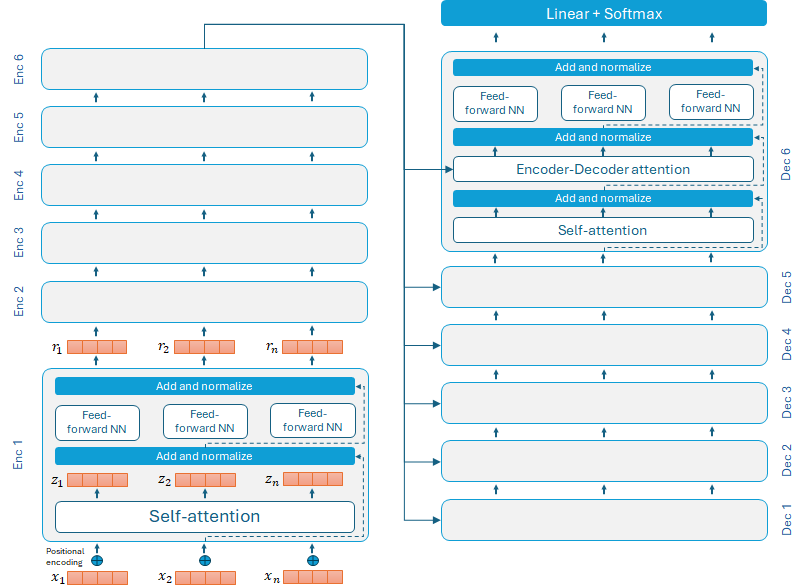

In the inference step, trained transfomer model essentially "translates" the input sequence to the output sequence, namely a forecast. In time series problem, the input sequence is $X = \{x_1, x_2,..,x_n\}$, where each $x_i$ is a vector corresponding to all input features data in $i$ datapoint.

All input vectors are entered into self-attention layer at once. Self-attention allows the model to focus on different parts of the input sequence when encoding or decoding information, capturing dependencies and relationships between them. It is a key component of transformer architectures and has been shown to perform well in various natural language processing tasks.

Self-attention process results with the attention score vector which actually quantify those dependencies. For calculating attention score, query, key and value matrices are computed based on the input sequence: $Q=XW_Q, K=XW_K, V=XW_V$, where $W_Q, W_K, W_V$ are learnable weight matrices.
The attention score is then computed as follows:

$A=softmax(\frac{QK^T}{\sqrt{d_k}})$

where $d_k$ is the dimension of key vectors. Finally, the output sequence is calculated as the weighted sum (where weights are actually attention scores) of the value vectors $V$, namely:

$Z(X)=AV$.

Multi-head attention is the concept that facilitates separation of focus on the different parts of the input sequence vectors, by looking (vertically) at the groups of features. Such an approach is known for improved representation learning (better capturing diverse patterns and dependencies), better interpretability (attention weights computed by each head provide insights on which groups of features are important for the forecast) and other benefits.

In this approach, attention scores and attention itself is calculated for each and every head, where number of features in the input sequence must be divisible by the number of heads. Overall attention is computed as concatenation of all the attention heads (where $m$ is the number of heads) multiplied with weight matrix:

$Z(X)=[Z_0, Z_1,.., Z_m]W^o$





The positional encoding is a technique used in transformer models to provide positional information to the input embeddings, allowing the model to understand the order of words in a sequence. Positional encoding is based on the sine and cosine functions. Given an input sequence of length $n$ and a dimension of input features data $d$, the positional encoding $PE_{(i,j)}$ for the $j$-th feature at position $i$ in the input sequence, is computed as follows:

$PE_{(i,2j)}=sin(\frac{i}{1000^{\frac{2j}{d}}})$

$PE_{(i,2j+1)}=cos(\frac{i}{1000^{\frac{2j}{d}}})$

The positional encoding vector for each position $i$ is then obtained by concatenating the values of $P_{(i,j)}$ across all dimensions $j$ of the input vector.

$PosEnc(i)=[PE_{(i,0)},PE_{(i,1)},..,PE_{(i,d-1)}]$

This positional encoding vector is then added element-wise to the corresponding input features vector to obtain the final input representation:

$Input(i)=x_i+PosEnc(i)$

The method described above is also called absolute positional encoding. In the subsequent research, relative positional encoding was proposed [Shaw et al, 2018] on the premise that pairwise positional encoding between two input feature vectors is more beneficial then their position.

Before feeding the data to the neural network, the input is normalized after the input sequence is again added to the multi-head attention output, as it follows:

$Z(X)=LayerNorm(Z(X)+X)$

Decoder elements are following the similar logic. However, some specific aspects are different.

First, while the encoded representation of input sequence is feeded to the decoder part of the architecture, encoder also provide key and value matrices to the Encoder-Decoder attention elements, enabling the decoder to focus on relevant parts of the input sequences while generating the output. This layer works just like multiheaded self-attention, except that it creates its Q matrix from the layer below it, and takes the K and V matrix from the output of the encoder stack.

Second, the decoder operates in autoregressive manner to generate the output sequence step by step. Here, the self-attention layer is only allowed to attend only to earlier positions in the output sequence. This is done by masking future positions before the softmax step in the self-attention calculation.

The output of the decoder is a sequence of hidden states, where each hidden state represents the model's prediction for a particular time step in the forecast horizon. These hidden states are passed through a linear layer, which applies a linear transformation to map the hidden states to a higher-dimensional space. The output of the linear layer is then passed through a softmax layer, which normalizes the values across the forecast horizon to obtain a probability distribution over the possible future values. The softmax function ensures that the predicted probabilities sum to 1, allowing the model to output a probability distribution for each time step. The final step involves selecting the most likely value for each time step based on the predicted probability distributions. This can be done by taking the argmax of the softmax output at each time step, resulting in a point forecast for each future time step.

##Implementation

A simple Transformer architecture tailored for time series forecasting was used in this case, with implementation with the PyTorch library.

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 33.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from torchmetrics import MeanAbsoluteError, MeanSquaredError

Model is trained by using data from L12 substation.

In [ ]:
data=all_data[3]

In [ ]:
print(data.index.min(), data.index.max(), len(data))

2019-11-01 07:00:00 2024-04-01 05:00:00 38710


We are adding past 24 values of transmitted energy as features. Since heat demand exhibits very strong daily seasonability and similar daily consumption patterns, we want to emphasize that to the model by introducing past 24 hours transmitted energy data in the input data vector. Given that the size of input vector is 24, this practically means that we are using data from past 48 hours to forecast the energy demand in next 24 hours.

In [ ]:
num_lags = 24

# Create lagged features for deltae
for lag in range(1, num_lags + 1):
    data[f'deltae_lag_{lag}'] = data['deltae'].shift(lag)

# Remove rows with NaN values that result from shifting
data = data.dropna()

We are adding weather forecast, namely temperature forecasts in next 24 hours. As we are using actual meteo station readings, future 24 hours of the readings are introduced to the input data vector. Obviously, that's not the forecast. Under the assumption of accurate forecasts, that's a good alternative.

In [ ]:
# Create lagged features for deltae
for lag in range(1, 25):
    data[f'temp_next_{lag}'] = data['temp'].shift(-lag)

# Remove rows with NaN values that result from shifting
data = data.dropna()

<ipython-input-18-fcab691d2e1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'temp_next_{lag}'] = data['temp'].shift(-lag)
<ipython-input-18-fcab691d2e1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'temp_next_{lag}'] = data['temp'].shift(-lag)
<ipython-input-18-fcab691d2e1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38662 entries, 2019-11-02 07:00:00 to 2024-03-31 05:00:00
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              38662 non-null  float64
 1   feelslike         38662 non-null  float64
 2   humidity          38662 non-null  float64
 3   snowdepth         38662 non-null  float64
 4   sealevelpressure  38662 non-null  float64
 5   solarradiation    38662 non-null  float64
 6   hour_of_day       38662 non-null  int32  
 7   heating_on        38662 non-null  int64  
 8   deltae            38662 non-null  float64
 9   deltae_lag_1      38662 non-null  float64
 10  deltae_lag_2      38662 non-null  float64
 11  deltae_lag_3      38662 non-null  float64
 12  deltae_lag_4      38662 non-null  float64
 13  deltae_lag_5      38662 non-null  float64
 14  deltae_lag_6      38662 non-null  float64
 15  deltae_lag_7      38662 non-null  float64
 16  delta

The dataset is preprocessed, normalized, and converted it into PyTorch tensors. PyTorch tensors are the fundamental data structures used in PyTorch, a popular open-source machine learning library. PyTorch tensors can store multi-dimensional data with different data types supported. PyTorch includes a wide array of operations for tensor manipulation, including mathematical operations, slicing, reshaping, and more. These operations are optimized for performance and are integral to developing efficient machine learning models. PyTorch tensors are interoperable with other data structures, such as Numpy. They can be moved between different devices, such as CPUs and GPUs, to accelerate computations.

Data loaders are also created. In PyTorch, data loaders are an essential component for efficiently handling and iterating over datasets. The primary purpose of a data loader is to load data in batches, which is crucial for training models on large datasets that do not fit into memory all at once.

In [ ]:
train_size=int(0.8*len(data))
train = data[:train_size]
test = data[train_size:]


# Selecting features and target
features = train.drop(columns=['deltae'])
target = train['deltae']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert to PyTorch tensors
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32).view(-1, 1)

# Input sequence length and future prediction length
N = 24  # Number of time steps in each input sequence
M = 24  # Number of time steps to predict

# Prepare sequences
sequences = [features_tensor[i:i+N] for i in range(len(features_tensor) - N - M + 1)]
targets = [target_tensor[i+N:i+N+M] for i in range(len(target_tensor) - N - M + 1)]

# Convert to tensors and create datasets
sequences_tensor = torch.stack(sequences)
targets_tensor = torch.stack(targets).view(len(targets), M)  # Ensure targets are properly shaped

# DataLoader setup
dataset = TensorDataset(sequences_tensor, targets_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)


# Test set handling (similar approach)
test_features = test.drop(columns=['deltae'])
test_target = test['deltae']
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as for the training data
test_features_tensor = torch.tensor(test_features_scaled, dtype=torch.float32)
test_target_tensor = torch.tensor(test_target.values, dtype=torch.float32).view(-1, 1)

# Prepare sequences for testing
test_sequences = [test_features_tensor[i:i+N] for i in range(len(test_features_tensor) - N - M + 1)]
test_targets = [test_target_tensor[i+N:i+N+M] for i in range(len(test_target_tensor) - N - M + 1)]

# Convert to tensors and create test dataset
test_sequences_tensor = torch.stack(test_sequences)
test_targets_tensor = torch.stack(test_targets).view(len(test_targets), M)  # Ensure targets are properly shaped

test_dataset = TensorDataset(test_sequences_tensor, test_targets_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

The TimeSeriesTransformer class is a custom neural network model built using PyTorch Lightning and designed for time series forecasting tasks. It utilizes the Transformer architecture, which is known for handling sequences and capturing dependencies across time.

Parameters:
- input_dim: The number of features in the input data. In the context of Transformers, this also corresponds to the d_model which is the size of the expected input embeddings.
- num_classes: The size of the output layer, which determines how many values the model predicts at each time step.
- dim_feedforward: The dimensionality of the feedforward network model in the transformer layers.
- nhead: The number of heads in the multi-head attention models.
- num_layers: The number of sub-encoder and sub-decoder layers in the transformer.
- dropout: The dropout rate, a regularization parameter to prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training.

Components:
- self.transformer: The Transformer model from PyTorch's neural network library. It is configured with both encoder and decoder layers having the same number of layers, head number, etc.
- self.linear_out: A linear layer that maps the Transformer’s output to the desired output size (num_classes). This layer acts as the final prediction layer.
- self.val_mae and self.val_rmse: Metrics from torchmetrics to compute the mean absolute error and the root mean square error, respectively. These are used to evaluate the model during validation.

In [ ]:
class PlotLossCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Append the loss from the current batch to the list of losses
        self.losses.append(outputs['loss'].item())

    def on_train_end(self, trainer, pl_module):
        # Plot the training loss curve
        plt.plot(np.arange(len(self.losses)), self.losses, label='Training Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.show()

class TimeSeriesTransformer(pl.LightningModule):
    def __init__(self, input_dim, num_outputs=24, dim_feedforward=512, nhead=4, num_layers=3, dropout=0.2):
        super().__init__()
        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        # Assuming each time step outputs one feature
        self.linear_out = nn.Linear(input_dim, 1)
        self.val_mae = MeanAbsoluteError()
        self.val_rmse = MeanSquaredError(squared=False)

    def forward(self, src):
        src = src.permute(1, 0, 2)  # [sequence_length, batch_size, features]
        output = self.transformer(src, src)
        output = self.linear_out(output)
        output = output.permute(1, 0, 2)  # [batch_size, sequence_length, num_outputs]
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        # Ensure y is [batch_size, sequence_length, num_outputs]
        y = y.view(y_hat.shape)  # Reshape y to match y_hat
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y = y.view(y_hat.shape)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.val_mae(y_hat.flatten(), y.flatten())
        self.val_rmse(y_hat.flatten(), y.flatten())
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        self.log('val_mae', self.val_mae.compute(), prog_bar=True)
        self.log('val_rmse', self.val_rmse.compute(), prog_bar=True)
        self.val_mae.reset()
        self.val_rmse.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

Number of heads (nhead) must be a divisor of input features count.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type              | Params
--------------------------------------------------
0 | transformer | Transformer       | 464 K 
1 | linear_out  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


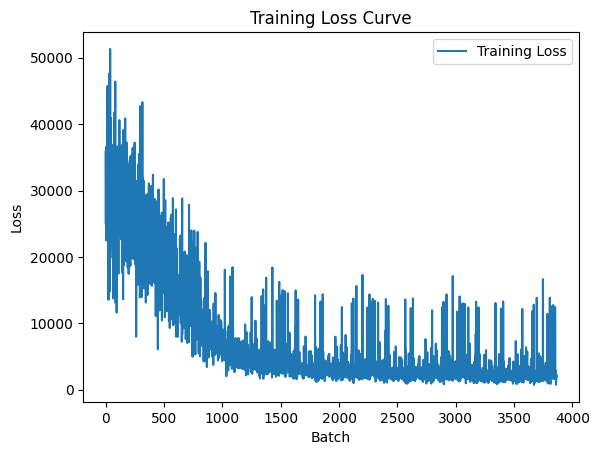

In [ ]:
# Initialize the model
model = TimeSeriesTransformer(input_dim=features_tensor.shape[1],
                              num_outputs=24,
                              nhead=7, # with weather forecast
                              #nhead=4, # without weather forecast
                              dim_feedforward=512,  # Size of the feedforward network
                              num_layers=3,  # Number of layers in the encoder and decoder
                              dropout=0.1)  # Dropout rate

# Create a PyTorch Lightning trainer and fit the model
trainer = pl.Trainer(max_epochs=5, accelerator='gpu', callbacks=[PlotLossCallback()], devices=1 if torch.cuda.is_available() else None)
#trainer = pl.Trainer(max_epochs=10, accelerator='cpu', callbacks=[PlotLossCallback()])
trainer.fit(model, train_loader, val_loader)

Finally, the model is evaluated.

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    mae_metric = MeanAbsoluteError()
    rmse_metric = MeanSquaredError(squared=False)
    with torch.no_grad():
        for x, y in test_loader:
            # Ensure x has the expected shape; assuming it's already correct, no need to unsqueeze
            y_hat = model(x)  # Forward pass

            # Reshape y_hat and y if necessary, ensure these tensors are compatible
            # Flatten the sequence and batch dimensions to treat all predictions equally
            y_hat_flat = y_hat.reshape(-1)  # Flatten all batches and sequences
            y_flat = y.reshape(-1)  # Flatten all batches and sequences

            # Update metrics
            mae_metric.update(y_hat_flat, y_flat)
            rmse_metric.update(y_hat_flat, y_flat)

    # Compute final metric values
    mae = mae_metric.compute()
    rmse = rmse_metric.compute()
    return mae.item(), rmse.item()

# Assuming 'model' is your trained model instance and 'test_loader' is set up
mae, rmse = evaluate_model(model, test_loader)
print(f"Mean Absolute Error on Test Set: {mae:.4f}")
print(f"Root Mean Square Error on Test Set: {rmse:.4f}")

Mean Absolute Error on Test Set: 21.0991
Root Mean Square Error on Test Set: 57.6080


Resulting MAE is actually an average of forecasting accuracies at different times in output vector of 24 hours. Below bar part shows exact accuracies at each of the different times. As expected, this accuracy degrades for the later time points, however, not as much as anticipated.

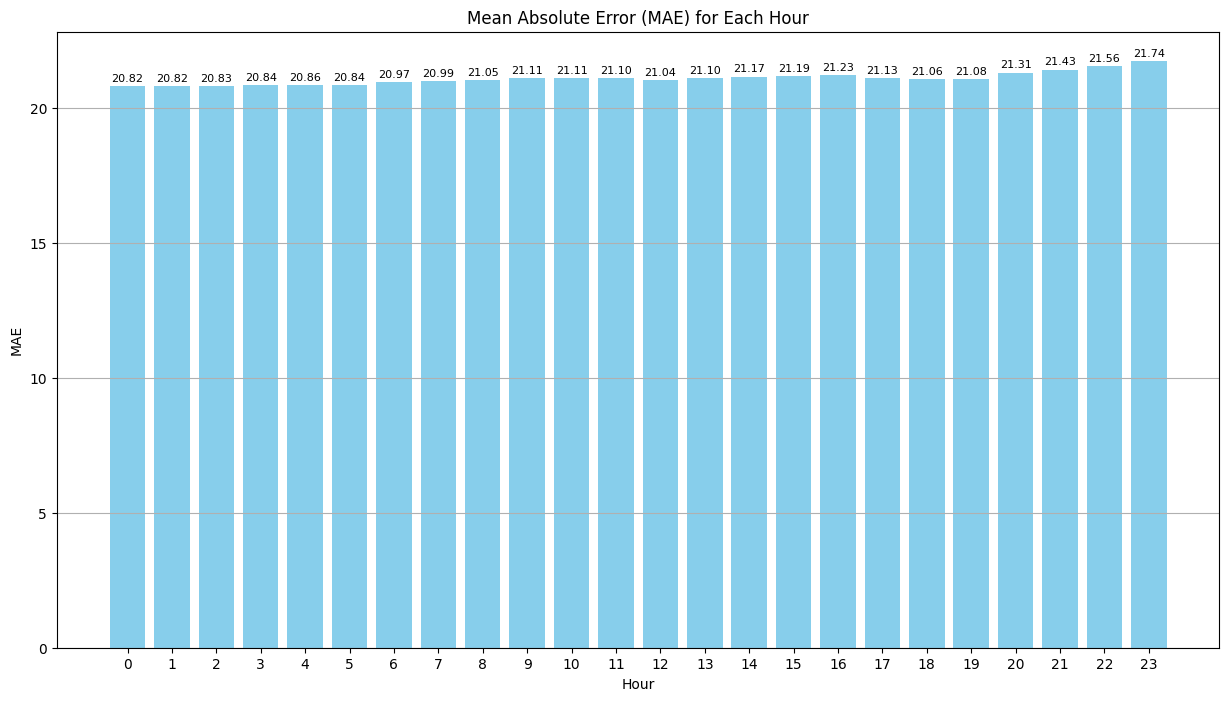

In [ ]:
hours = range(24)

# Plot the bar chart
plt.figure(figsize=(15, 8))  # Adjust the width and height as needed
bars = plt.bar(hours, maes, color='skyblue')
plt.xlabel('Hour')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) for Each Hour')
plt.xticks(hours)  # Ensure all hours are displayed on the x-axis
plt.grid(axis='y')  # Add grid lines along the y-axis

# Annotate each bar with its corresponding MAE value
for bar, mae in zip(bars, maes):
    plt.text(bar.get_x() + bar.get_width() / 2,  # x-coordinate of text
             bar.get_height()+0.1,                  # y-coordinate of text
             f'{mae:.2f}',                      # Text to display (formatted MAE value)
             ha='center', va='bottom',          # Text alignment
             color='black',                     # Text color
             fontsize=8)


plt.show()

Standard deviation of all accuracies is displayed.

In [ ]:
std = np.std(maes)

print("Standard Deviation:", std)

Standard Deviation: 0.22962380641058933


We are showing the visualizations of the alignment of actual values and forecasts at the different place in output sequence, on the data sample so to make the differences more distinguished.

In [ ]:
timepoint_index=0
hours_forecasts=[]
hours_actuals=[]
numhours=24

# Iterate over the test loader to get forecasts and actual values for the chosen timepoint
with torch.no_grad():
  for tp in range(0,numhours):
    forecasts = []
    actuals = []
    for inputs, targets in test_loader:
          # Make predictions using the model
          predictions = model(inputs)

          # Extract forecasts and actual values for the chosen timepoint from each sample in the batch
          for i in range(len(inputs)):
            # Extract forecasts and actual values for the specified timepoint from each sample
            forecast = predictions[i, tp].item()
            actual = targets[i, tp].item()

            # Append the forecasts and actual values to the respective lists
            forecasts.append(forecast)
            actuals.append(actual)
    hours_forecasts.append(forecasts)
    hours_actuals.append(actuals)

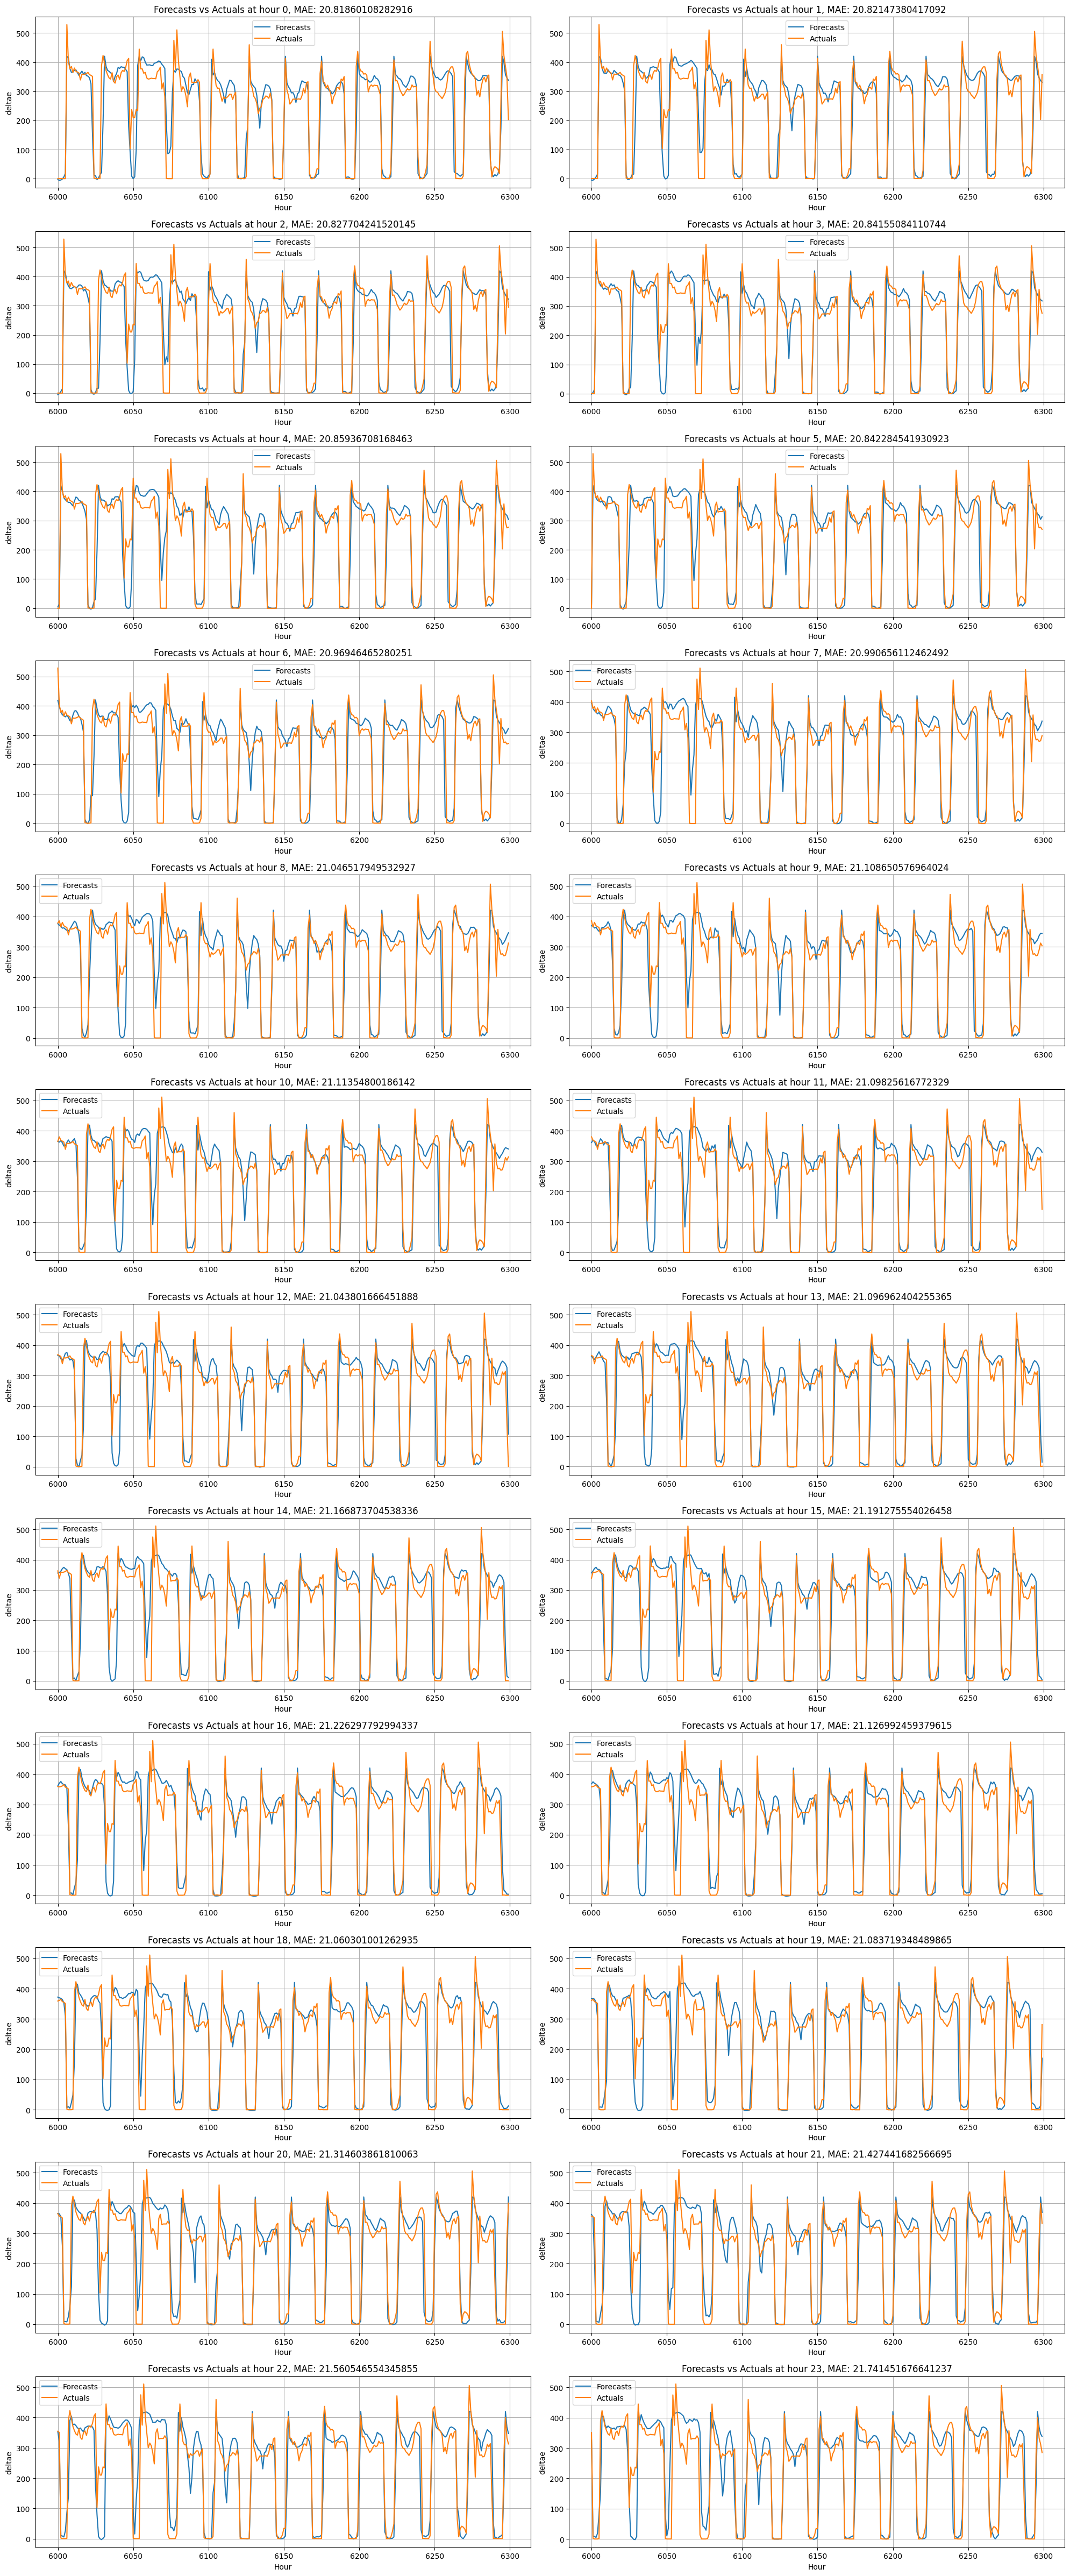

In [ ]:
start = 6000
end = 6300
num_hours = len(hours_forecasts)
maes=[]
# Create a figure with multiple subplots
num_rows = (num_hours + 1) // 2  # Number of rows for subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows*4))

# Iterate over the forecasts and actuals
for i in range(num_hours):
    actuals_array = np.array(hours_actuals[i])
    forecasts_array = np.array(hours_forecasts[i])
    mae = np.mean(np.abs(actuals_array - forecasts_array))
    maes.append(mae)
    row_index = i // 2  # Calculate the row index for the subplot
    col_index = i % 2   # Calculate the column index for the subplot

    # Plot the forecasts and actual values in the subplot
    ax = axes[row_index, col_index]
    hours = np.arange(len(hours_forecasts[i]))
    ax.plot(hours[start:end], hours_forecasts[i][start:end], label='Forecasts')
    ax.plot(hours[start:end], hours_actuals[i][start:end], label='Actuals')
    ax.set_xlabel('Hour')
    ax.set_ylabel('deltae')
    ax.set_title(f'Forecasts vs Actuals at hour {i}, MAE: {mae}')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#References

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). Attention Is All You Need. arXiv:1706.03762 [Cs]. http://arxiv.org/abs/1706.03762

Shaw, P., Uszkoreit, J., & Vaswani, A. (2018). Self-Attention with Relative Position Representations. https://doi.org/10.48550/ARXIV.1803.02155

